# Demo de implementación de un algoritmo de Programación Genética para obtener una fórmula matemática que se aproxime al comportamiento de un conjunto de datos
Ejemplo adaptado de https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


1) Importar librerías:

In [2]:
#@title
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image
#import networkx as nx

print("\nLibrerías importadas")


Librerías importadas


2) Definir los Datos (ENTRADA y SALIDA) para que intente aproximar la fórmula correspondiente:

In [3]:
#@title DATOS DE FUNCIÓN A APROXIMAR
# Para este ejemplo se trata de aproximar:  x al cubo más 1
ENTRADA = range(100)
SALIDA = []
for x in ENTRADA:
  SALIDA.append( x**3 + 10 )

print("Entradas: ", list(ENTRADA))
print("Salidas: ", SALIDA)

Entradas:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Salidas:  [10, 11, 18, 37, 74, 135, 226, 353, 522, 739, 1010, 1341, 1738, 2207, 2754, 3385, 4106, 4923, 5842, 6869, 8010, 9271, 10658, 12177, 13834, 15635, 17586, 19693, 21962, 24399, 27010, 29801, 32778, 35947, 39314, 42885, 46666, 50663, 54882, 59329, 64010, 68931, 74098, 79517, 85194, 91135, 97346, 103833, 110602, 117659, 125010, 132661, 140618, 148887, 157474, 166385, 175626, 185203, 195122, 205389, 216010, 226991, 238338, 250057, 262154, 274635, 287506, 300773, 314442, 328519, 343010, 357921, 373258, 389027, 405234, 421885, 438986, 456543, 474562, 493049, 512010, 531451, 551378, 571797,

3) Inicializar objetos de DEAP para utilizar y especificar Primitivas, Estructura del Cromosoma + Función de Aptitud y Operadores Genéticos:

In [4]:
#@title Inicializar valores de la librería DEAP

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## PRIMITIVAS QUE SE VAN A UTILIZAR 
## PARA GENERAR EL ÁRBOL DE LA FÓRMULA MATEMÁTICA
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("c"+str(random.randint(0,100)), lambda: random.randint(-99,99))
pset.addEphemeralConstant("c"+str(random.randint(0,100)), lambda: random.randint(-99,99))

pset.renameArguments(ARG0='x')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def calculaError(individual):
    # Transforma la expresión del árbol en una función que se puede ejecutar
    try:
      func = toolbox.compile(expr=individual)
    except MemoryError:
      # si tira error por BLOAT devuelve un error muy grande para descartarlo
      return 9999

    # calcula la diferencia entre lo que devuelve la función y el valor Y
    sqerrors = ((func(x) - y)**2 for x, y in zip(ENTRADA, SALIDA))
    # calcula el promedio del error total
    return math.fsum(sqerrors) / len(ENTRADA),

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


In [5]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100 #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.1 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 30 #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 #@param {type:"slider", min:0, max:1, step:0.05}

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.2  #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    ciclosMinIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMinIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (auxMin > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            hijo1, hijo2 = toolbox.mate(hijo1, hijo2)
            #toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values
            
    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmin( ciclosMinAptitud )

print("\n== Mejor Individuo de la Corrida:", ciclosMinIndiv[mejorCiclo], " { ", ciclosMinAptitud[mejorCiclo], " } ==")


-- Ciclo  0 --
 Mejor Individuo: mul(-68, -11)  { 137546028934.5 }
   Max:  198984676226.5  / Promedio:  140425391237.08  / Min:  137546028934.5

-- Ciclo  1 --
 Mejor Individuo: mul(17, add(x, x))  { 136589577192.1 }
   Max:  478019048896.3  / Promedio:  149590171634.87  / Min:  136589577192.1

-- Ciclo  2 --
 Mejor Individuo: add(50, 50)  { 137863044790.5 }
   Max:  180065541843.17  / Promedio:  139654071087.17  / Min:  137863044790.5

-- Ciclo  3 --
 Mejor Individuo: add(add(x, x), -33)  { 137850206476.3 }
   Max:  137917471716.81  / Promedio:  137903603905.38  / Min:  137850206476.3

-- Ciclo  4 --
 Mejor Individuo: protectedDiv(sub(cos(x), mul(90, x)), -33)  { 137805681170.42 }
   Max:  137951056169.61  / Promedio:  137903671093.04  / Min:  137805681170.42

-- Ciclo  5 --
 Mejor Individuo: protectedDiv(sub(cos(x), mul(90, x)), sub(protectedDiv(78, -8), cos(87)))  { 137572098569.0 }
   Max:  141449327234.5  / Promedio:  138011223044.25  / Min:  137572098569.0

-- Ciclo  6 --
 Mejo


> Mejor Individuo de la Corrida:


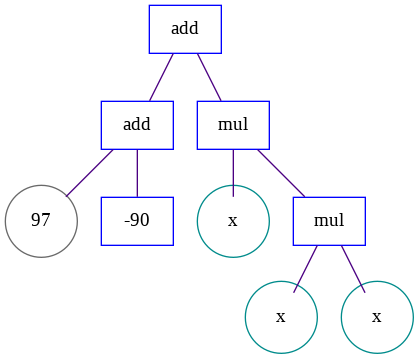



add(add(97, -90), mul(x, mul(x, x)))


  x 		 yREAL 		 yCALC
--------------------------------------------------------
   0 		 10 		 7
   1 		 11 		 8
   2 		 18 		 15
   3 		 37 		 34
   4 		 74 		 71
   5 		 135 		 132
   6 		 226 		 223
   7 		 353 		 350
   8 		 522 		 519
   9 		 739 		 736
   10 		 1010 		 1007
   11 		 1341 		 1338
   12 		 1738 		 1735
   13 		 2207 		 2204
   14 		 2754 		 2751
   15 		 3385 		 3382
   16 		 4106 		 4103
   17 		 4923 		 4920
   18 		 5842 		 5839
   19 		 6869 		 6866
   20 		 8010 		 8007
   21 		 9271 		 9268
   22 		 10658 		 10655
   23 		 12177 		 12174
   24 		 13834 		 13831
   25 		 15635 		 15632
   26 		 17586 		 17583
   27 		 19693 		 19690
   28 		 21962 		 21959
   29 		 24399 		 24396
   30 		 27010 		 27007
   31 		 29801 		 29798
   32 		 32778 		 32775
   33 		 35947 		 35944
   34 		 39314 		 39311
   35 		 42885 		 42882
   36 		 46666 		 46663
   37 		 50663 		 50660
   38 		 54882 		 54879
   39 		 59329 		 59326
   40 

In [8]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN 
## CORRESPONDIENTE AL MEJOR INDIVIDUO 
print("\n> Mejor Individuo de la Corrida:")
nodes, edges, labels = gp.graph( ciclosMinIndiv[mejorCiclo] )

g = pgv.AGraph()
g.graph_attr['label']=''
g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='x':
      n.attr['shape']='circle'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'


# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")
g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

# Aplica y muesta el resultado
print("\n")
print( ciclosMinIndiv[mejorCiclo] )
func = toolbox.compile(expr=ciclosMinIndiv[mejorCiclo])
print("\n")
print("  x \t\t yREAL \t\t yCALC")
print("--------------------------------------------------------")
for x, y in zip(ENTRADA, SALIDA):
  print("  ", x, "\t\t", y, "\t\t", func(x))


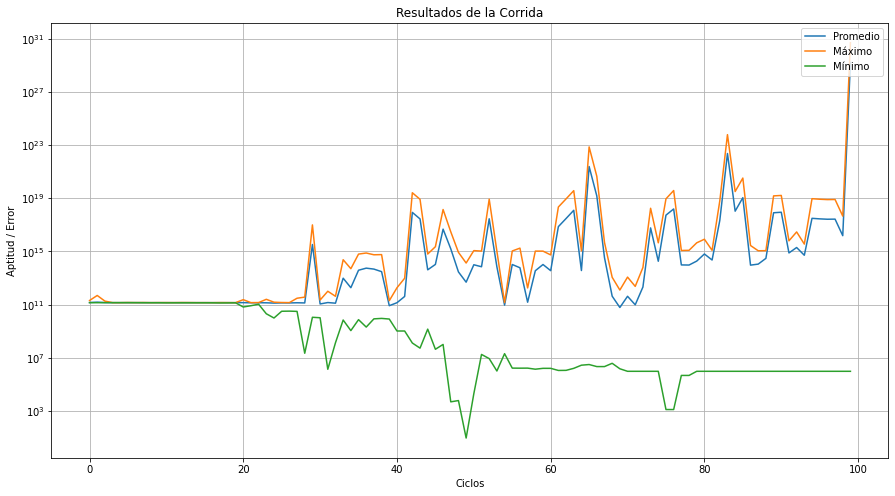

In [9]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.yscale('log')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')
plt.grid(True)

plt.show()